# Central Limit Theorem: Visualization and results

<div align="left" style="text-align: left;">
    Author: <i>Gabriele Aldeghi</i><br>
    Date: September 2023
</div>

The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) (**CLT**) is a cardinal theorem in probability. The theorem states that the sample mean of indipendent and identically distributed random variables extracted from a distribution will resemble a Gaussian distribution, the bigger the sample distribution is.

Formally, the theorem is outlined like this.
Given $X_1$, $X_2$, ..., $X_n$ indipended random variables sampled from a distribution, the **CTL** states that the normalized mean of the sampled distribution with finite standard deviation $\sigma$ is distributed as a Gaussian distribution of $\mu=0$ and $\sigma=1$.

\begin{equation}
\lim_{n\to\infty} \frac{\overline{X_n} - \mu}{\frac{\sigma}{\sqrt{n}}} \sim \mathcal{N}(0, 1)
\end{equation}

Where $\overline{X_n}$ is the mean of the sampled distribution.

\begin{equation}
\overline{X_n} = \frac{\sum_{i=0}^{n}X_i}{n}
\end{equation}

This means that, with some math, we can prove that $\overline{X_n}$ converges to:

\begin{equation}
\lim_{n\to\infty} \overline{X_n} \sim \mathcal{N}(\mu, \frac{\sigma^2}{n})
\end{equation}

By remembering some basic properies of expected values:

\begin{equation}
a + \mathbb{E}[X]=\mathbb{E}[a +X]
\qquad \qquad
a\mathbb{E}[X]=\mathbb{E}[aX]
\qquad \qquad
a^2\mathbb{V}[X] = \mathbb{V}[aX]
\end{equation}

In this notebook, we'll explore the sampling distribution obtained from Beta distribution, and plot the obtained distributions to visualize the results of the **CTL**.

In [1]:
from typing import Optional

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from ipywidgets import interactive
import statsmodels.api as sm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from utils import print_info

SEED = 27
np.random.seed(SEED)

# Beta distribution example

The [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution) is represented as:
\begin{equation}
f(x; \alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}
x^{\alpha - 1}(1 - x)^{\beta - 1}
\end{equation}
Where the mean and standard deviation are, respectively:
\begin{equation}
\mu=\mathbb{E}[X]=\frac{\alpha}{\alpha + \beta}
\qquad \qquad
\sigma^2=\mathbb{V}[X]=\frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}
\end{equation}

We will use this distribution to prove the core idea behind the *Central Limit Theorem*.

The Beta distribution is bounded between $(0,1)$. For our purposes, let's generate samples from an unknown $100B(\alpha, \beta)$ distribution to have $\mu$ and $\sigma$ values higher than $1$. We'll show the *Central Limit Theorem* core idea over this distribution.


First, let's randomly generate two values for alpha and beta, and visualize the distribution.

In [2]:
def beta_mean(alpha: float, beta: float) -> float:
    return alpha / (alpha + beta)

def beta_variance(alpha: float, beta: float) -> float:
    return (alpha * beta) / (pow(alpha + beta, 2) * (alpha + beta + 1))

In [3]:
alpha, beta = np.random.random(size=2) * [5, 20]

mu = beta_mean(alpha, beta) * 100
sigma = np.sqrt(beta_variance(alpha, beta)) * 100

In [4]:
def sample_beta_population(sample_size: int = 100000) -> np.ndarray:
    return (np.random.beta(
        a=alpha,
        b=beta,
        size=sample_size,
    ) * 100)

Let's visualize the sampling distribution.

<Axes: ylabel='Density'>

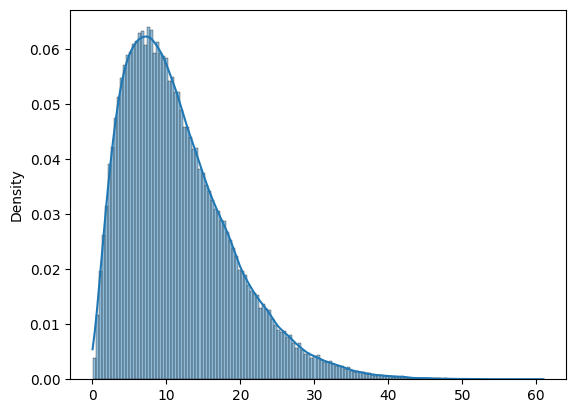

In [5]:
sns.histplot(
    sample_beta_population(), 
    stat="density",
    kde=True,
)

Now, let's sample for `repetitions` times a subpopulation of *n=*`subpopulation_samples`. Of these sampled distributions, we'll compute the means.

This sampling distributions are used to approximate $\overline{X_n}$. As outlined before, we expect $\overline{X_n}$ to behave as gaussian distribution $\mathcal{N}(\mu, \frac{\sigma^2}{n})$. In the interactive widget, we can vary the size of the $n$ to see how different subsampling sizes affect the expected distribution (highlighted in red).

In [6]:
max_n = 10000

def sample(n: int, repetitions: int = 250) -> pd.DataFrame:
    return pd.DataFrame(
        [
            sample_beta_population(n).mean()
            for _ in range(repetitions)
        ],
        columns=["means"],
    )

In [7]:
def plot_histogram_means(
    n: int,
    repetitions: int = 250,
):
    means = sample(n, repetitions)
    g = sns.histplot(
        means,
        bins=20,
        stat="density",
        label="means",
    )
    gaussian_x = np.linspace(*g.get_xlim(), 200)
    gaussian_y = scipy.stats.norm.pdf(
        gaussian_x,
        loc=mu,
        scale=sigma / np.sqrt(n),
    )
    g.plot(
        gaussian_x, 
        gaussian_y,
        'r',
        lw=2,
        label='Expected Gaussian by CLT',
    ) 
    g.legend()
    g.set_title(
        r"E[$\overline{X_n}]" + rf"={means['means'].mean():.3f}$   "
        rf"$\mu={mu:.3f}$"
        "\n"
        r"$\sqrt{V[\overline{X_n}]}" + f"={means['means'].std():.3f}$   "
        r"$\frac{\sigma}{\sqrt{n}}" f"={sigma / np.sqrt(n):.3f}$"
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

interactive_plot = interactive(
    lambda n: plot_histogram_means(n),
    n=widgets.IntSlider(
        min=10, 
        max=max_n, 
        step=1, 
        value=10,
    ),
)
interactive_plot

interactive(children=(IntSlider(value=10, description='n', max=10000, min=10), Output()), _dom_classes=('widge…

Similarly, we can show how $\frac{\overline{X_n} - \mu}{\frac{\sigma}{\sqrt{n}}}$ behaves with different $n$, and how it approximates to a standard normal.

In [8]:
def plot_normalized_means(
    n: int,
    repetitions: int = 250,
    means: Optional[pd.DataFrame] = None,
):
    if means is None:
        means = sample(n, repetitions)
        means = ((means - mu)) / (sigma / np.sqrt(n))
        
    g = sns.histplot(
        means,
        bins=20,
        stat="density",
        label="means",
    )
    standard_normal_x = np.linspace(*g.get_xlim(), 200)
    standard_normal_y = scipy.stats.norm.pdf(standard_normal_x)
    g.plot(
        standard_normal_x, 
        standard_normal_y,
        'r',
        lw=2,
        label='Standard Normal Gaussian expected by CLT',
    ) 
    g.legend()
    g.set_title(
        r"$E[\overline{X_n}]="
        f"{means['means'].mean():.3f}$"
        "\n"
        r"$V[\overline{X_n}]="
        f"{means['means'].var():.3f}$"
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

interactive_plot = interactive(
    lambda n: plot_normalized_means(n),
    n=widgets.IntSlider(
        min=10, 
        max=max_n, 
        step=1, 
        value=10,
    ),
)
interactive_plot

interactive(children=(IntSlider(value=10, description='n', max=10000, min=10), Output()), _dom_classes=('widge…

A way to properly assess the whether normalized sampled mean behaves like a standard normal distribution is to use the [Kolgomorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). The test compares can compare the Cumulative Probability Function (**CPF**) of our sampled distribution against the true **CPF** of a $\mathcal{N}(0, 1)$ distribution. By default, the `scipy.stats.kstest` uses a two-tailed test.

Let's take a sample with $n=1000$, and let's replicate it $10000$ times for numerical stability.

In [9]:
np.random.seed(SEED)

n = 1000
means = sample(n, repetitions=10000)
means = ((means - mu)) / (sigma / np.sqrt(n))

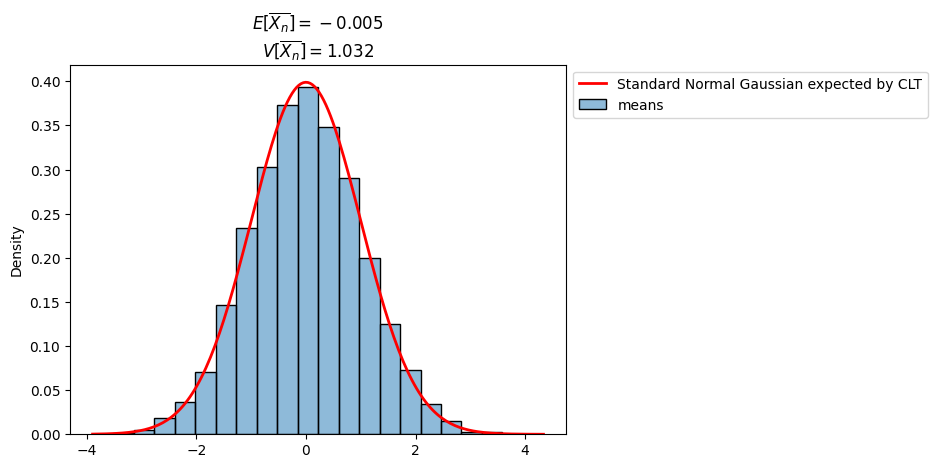

In [10]:
plot_normalized_means(n, means=means)

In [11]:
ks = scipy.stats.kstest(means["means"], "norm")
ks.statistic, ks.pvalue

(0.009249771253195982, 0.35701374536580444)

Given a confidence interval of $\alpha=0.95$, we see our p-value is way higher than $0.05$, giving us enough confidance that there is no statistical differences between our computed distribution and the standard normal $\mathcal{N}(0, 1)$, the null hypothesis.  

Another way to compare the distribution of $\overline{X_n}$ with the standard normal with a Quantile-Quantile Plot ([**QQ plot**](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)). 
In a graph the quantiles of two distributions are plotted against each other, and allows to compare in a graphical way the two distributions. When the distributions quantiles behave similarly, the plot points will fall on the bisector.

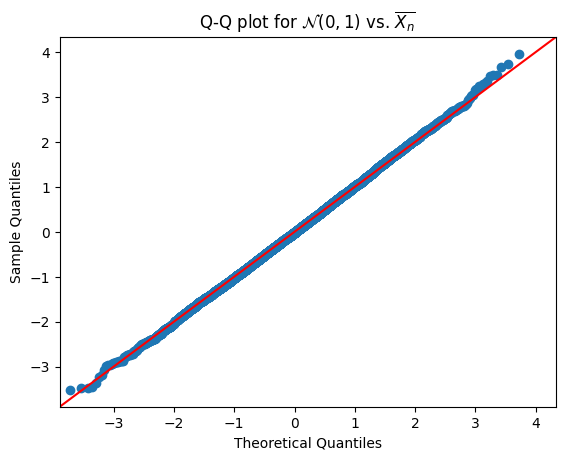

In [12]:
sm.qqplot(means["means"], line="45")
plt.title(r"Q-Q plot for $\mathcal{N}(0, 1)$ vs. $\overline{X_n}$")
plt.show()

While there is a slight mismatch at the initial and ending quantiles, the points perfectly lined up on the bisector, suggesting that in fact, the sample distribution behaves like a gaussian.

# Convergence of $\mu$ and $\sigma^2$

Let's plot how the expected values for $\overline{X_n}$ vary, depending on how $n$ increases. For this plot, let's use 100 repetitions for each $n$.

In [13]:
np.random.seed(SEED)

means, variances = [], []
ns = [i for i in range(2, 1000)]
for n in ns:
    samples = sample(n, repetitions=100)["means"]
    means.append(samples.mean())
    variances.append(samples.var())

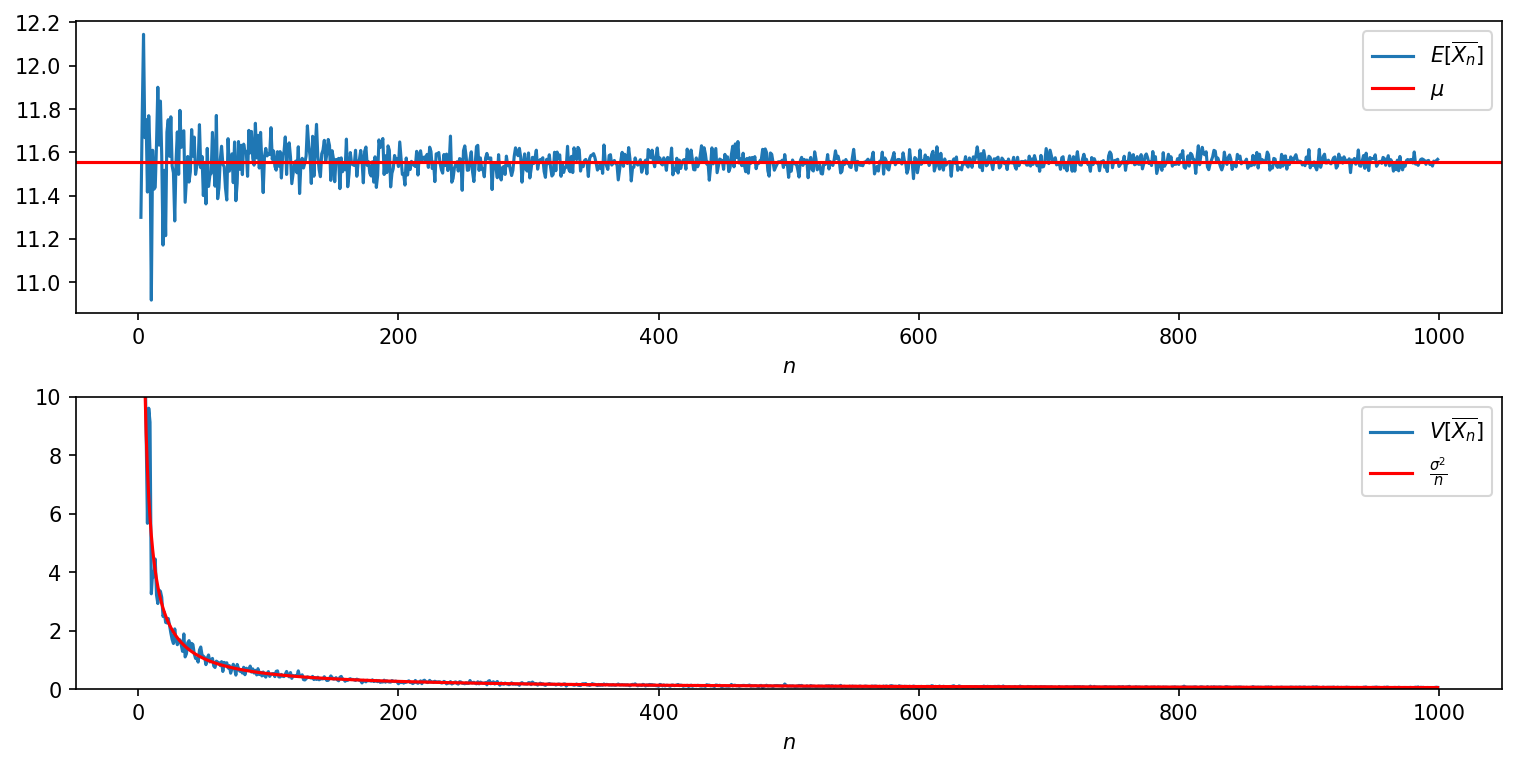

In [14]:
fig, axs = plt.subplots(
    nrows=2,
    figsize=(10, 5),
    dpi=150,
    layout="constrained",
)
sns.lineplot(
    y=means,
    x=ns,
    ax=axs[0],
    label=r"$E[\overline{X_n}]$",
)
axs[0].axhline(mu, color="red", label="$\mu$")
axs[0].set_xlabel("$n$")
axs[0].legend()
sns.lineplot(
    y=variances,
    x=ns,
    ax=axs[1],
    label=r"$V[\overline{X_n}]$",
)
axs[1].plot(
    ns, 
    sigma ** 2 / np.array(ns), 
    color="red", 
    label=r"$\frac{\sigma^2}{n}$",
)
axs[1].set_ylim((0, 10))
axs[1].legend()
axs[1].set_xlabel("$n$")
plt.show()

As we can see, as $n$ increases, the approximation of $\overline{X_n}$ get's closer and closer to the expected values of $\mu$ and $\frac{\sigma^2}{n}$.

# System Information

In [15]:
print_info(globals_items=globals())

System:
	- Machine: macOS-13.4.1-arm64-arm-64bit
	- Python Version: 3.9.16
	- RAM: 8 GB
Packages: 
	statsmodels==0.14.0
	matplotlib==3.7.1
	scipy==1.10.1
	pandas==2.0.2
	ipywidgets==8.0.6
	numpy==1.24.3
	seaborn==0.12.2
